Adapted from:
https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution 

https://www.kaggle.com/danofer/sarcasm/version/4

# Load dataset from kaggle


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d danofer/sarcasm

 95% 205M/216M [00:02<00:00, 53.4MB/s]
100% 216M/216M [00:02<00:00, 90.1MB/s]


In [ ]:
!unzip sarcasm.zip

Archive:  sarcasm.zip
  inflating: test-balanced.csv       
  inflating: test-unbalanced.csv     
  inflating: train-balanced-sarc.csv.gz  
  inflating: train-balanced-sarcasm.csv  


# Import and data processing

In [ ]:
# Imports

import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
train_df = pd.read_csv("train-balanced-sarcasm.csv")
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [ ]:
# Some comments missing so we drop the comment column
train_df.dropna(subset=['comment'], inplace=True)

In [ ]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [ ]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'], random_state=17)

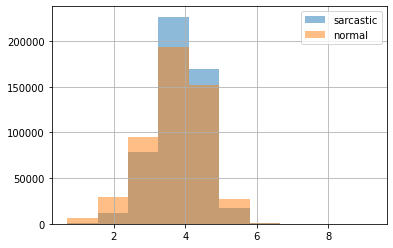

In [ ]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [ ]:
stopwords = ["the", "a", "an", "she", "he", "i", "you", "me", "they",
             "her", "his", "your", "their", "my", "we", "our", "ours",
             "hers", "yours", "it", "its", "him", "them", "theirs",
             "this", "that", "is", "was", "are", "were", "am", "or",
             "as", "of", "at", "by", "for", "with", "to", "from", "in",
             "m", "s", "ve", "d", "ll", "o", "re"]

# vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70)
# train_bow = vect.fit_transform(train_texts)
# train_bow.shape

# Model Training

## BoW - Bag of Words Model


In [ ]:
bow = CountVectorizer(ngram_range=(1, 1), max_features=50000, min_df=2)
logit = sklearn.linear_model.LogisticRegression(C=1, n_jobs=4, solver='lbfgs', verbose=1)


In [ ]:
X_train_texts = bow.fit_transform(train_texts)
X_valid_texts = bow.transform(valid_texts)

In [ ]:
logit.fit(X_train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.8s finished


LogisticRegression(C=1, n_jobs=4, verbose=1)

In [ ]:
valid_pred = logit.predict(X_valid_texts)
valid_pred_proba = logit.predict_proba(X_valid_texts)

In [ ]:
print("Accuracy:", accuracy_score(y_valid, valid_pred))
print("Precision score:", precision_score(y_valid, valid_pred))
print("Recall score:", recall_score(y_valid, valid_pred))
print("f1 score:", f1_score(y_valid, valid_pred))
print("ROC_AUC score:", roc_auc_score(y_valid, valid_pred))

Accuracy: 0.6920029759313636
Precision score: 0.7117304891555548
Recall score: 0.6457360783631099
f1 score: 0.6771290960909012
ROC_AUC score: 0.6920172617169446


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


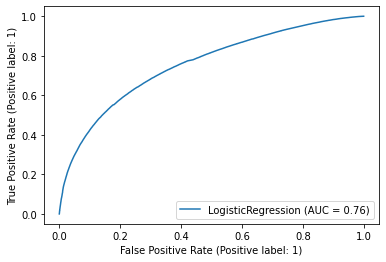

In [ ]:
plot_roc_curve(logit, X_valid_texts, y_valid)

## TF-IDF using LogReg Classifier

Term Frequency = No. of repetition of words in a sentence / No. of words in sentence

Inverse Document Frequency = log(No. of sentences / No. of sentences containing words)

TF(word) * IDF(word)

Limitations: Exclamation marks (Non-words) 

In [ ]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
# tf_idf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000, min_df=2)
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = sklearn.linear_model.LogisticRegression(C=1, n_jobs=4, solver='lbfgs', verbose=1)


https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe 

fit_transform() on training data but transform() on test data.

fit_transform() scales the training data and learns the scaling parameters.

We want scaling to be applied to our test data too but do not want it to be biased with our model.

In [ ]:
X_train_texts = tf_idf.fit_transform(train_texts)
X_valid_texts = tf_idf.transform(valid_texts)

In [ ]:
logit.fit(X_train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.9s finished


LogisticRegression(C=1, n_jobs=4, verbose=1)

In [ ]:
valid_pred = logit.predict(X_valid_texts)
valid_pred_proba = logit.predict_proba(X_valid_texts)


In [ ]:
print("Accuracy:", accuracy_score(y_valid, valid_pred))
print("Precision score:", precision_score(y_valid, valid_pred))
print("Recall score:", recall_score(y_valid, valid_pred))
print("f1 score:", f1_score(y_valid, valid_pred))
print("ROC_AUC score:", roc_auc_score(y_valid, valid_pred))

Accuracy: 0.7216870998124213
Precision score: 0.7389351109898729
Recall score: 0.6858591932650768
f1 score: 0.7114085697637201
ROC_AUC score: 0.7216981623607583


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


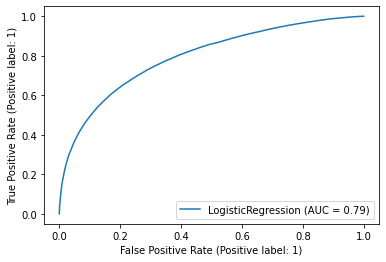

In [ ]:
plot_roc_curve(logit, X_valid_texts, y_valid)

## TF-IDF using SVM classifier

In [ ]:
from sklearn.svm import LinearSVC 

In [ ]:
# svm_model = SGDClassifier(penalty="elasticnet", random_state=42, n_jobs=4)
svm_model = LinearSVC()

In [ ]:
X_train_texts = tf_idf.fit_transform(train_texts)
X_valid_texts = tf_idf.transform(valid_texts)

In [ ]:
svm_model.fit(X_train_texts, y_train)

LinearSVC()

In [ ]:
valid_pred = svm_model.predict(X_valid_texts)

In [ ]:
print("Accuracy:", accuracy_score(y_valid, valid_pred))
print("Precision score:", precision_score(y_valid, valid_pred))
print("Recall score:", recall_score(y_valid, valid_pred))
print("f1 score:", f1_score(y_valid, valid_pred))
print("ROC_AUC score:", roc_auc_score(y_valid, valid_pred))

Accuracy: 0.6858928189826431
Precision score: 0.6974158275314728
Recall score: 0.6570506226955517
f1 score: 0.6766317522009965
ROC_AUC score: 0.6859017245599239


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


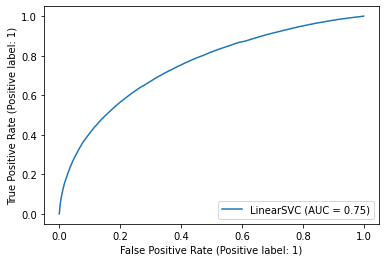

In [ ]:
plot_roc_curve(svm_model, X_valid_texts, y_valid)

# Download weights of tf vectorizer and logistic regression 

In [ ]:
import pickle
pickle.dump(tf_idf, open("tf_idf.pickle", "wb"))
pickle.dump(logit, open("logit.pickle", "wb"))

# WANDB Visualization charts

https://wandb.ai/shaokiat/tf-idf-model/runs/1pa00zrl?workspace=user-shaokiat 

Accuracy with Stop words: 0.7132104442527325

Accuracy without stop words: 0.7207215050614577

Accuracy (ngram_range=(1, 3)): 0.7218374793228173

Accuracy (ngram_range=(1, 4)): 0.7216870998124213

In [ ]:
accuracy_score(y_valid, valid_pred)

0.6539965333565498

In [ ]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """ 
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

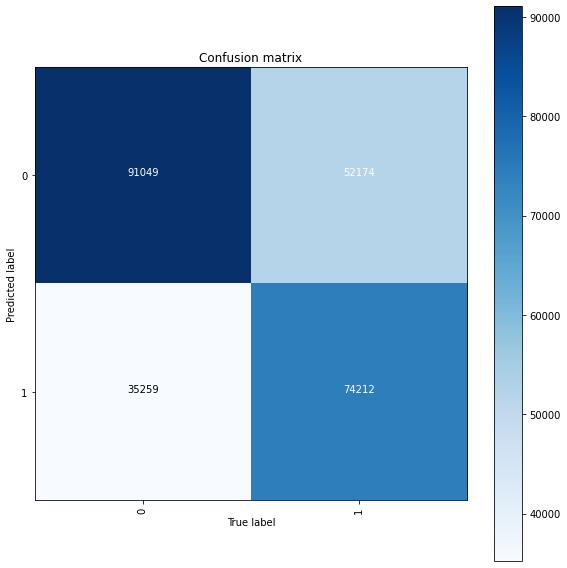

In [ ]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

Confusion matrix is quite balanced. False negatives ~ False positives



# Iteration 2
Improve model by separating Comments and Subreddits

In [ ]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [ ]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

# Difference in ngram_range() as subreddits are normally 1-word

In [ ]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 1min 22s, sys: 2.95 s, total: 1min 25s
Wall time: 1min 24s


In [ ]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [ ]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 3.78 s, sys: 16.2 ms, total: 3.8 s
Wall time: 3.82 s


In [ ]:
X_train_subreddits.shape, X_valid_subreddits.shape


((758079, 13255), (252694, 13255))

Stack both features together

In [ ]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [ ]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

In [ ]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.7s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Accuracy with ngram(1,2): 0.7237844982468915

Accuracy with ngram(1,3): 0.7253001654174615

# Evaluation Metrics

In [ ]:
print("Precision score:", precision_score(y_valid, valid_pred))
print("Recall score:", recall_score(y_valid, valid_pred))
print("f1 score:", f1_score(y_valid, valid_pred))


Precision score: 0.7397628085887196
Recall score: 0.695401389394395
f1 score: 0.7168964856256091


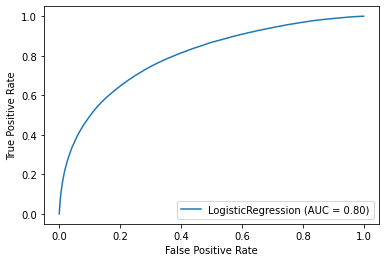

In [ ]:
plot_roc_curve(logit, X_valid, y_valid)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
train_data = pd.read_csv("appended_df.csv")
train_data = train_data.drop(['Predicted label', 'label', 'Special characters?', 'Comment length', 'caps'], axis = 1)
train_data

,comment
0,"Yeah they better nerf amumu NOW, Im sick of th..."
1,"the population matters, and it especially matt..."
2,"Exactly, the world most of us live in."
3,"It's Chinese, it has to be cruel!"
4,Stupid kids are job creators.
...,...
13152,Because spikes.
13153,Cole also felt weird when he saw himself in th...
13154,"I would notice the ""lazy nipple"", but it would..."
13155,i like the mental image of you trying that and...


In [ ]:
sub_pops = ['Special characters?','Comment length','caps']

In [ ]:
cm = pd.DataFrame(confusion_matrix(train_data['label'], train_data['Predicted label']))
cm.columns = ['True Non Sarcastic','True Sarcastic']
cm.index = ['Predicted Non Sarcastic','Predicted Sarcastic']
ref = pd.DataFrame([['TN','FN'],['FP','TP']])
display(cm),display(ref)

,True Non Sarcastic,True Sarcastic
Predicted Non Sarcastic,80371,20462
Predicted Sarcastic,28193,73123


,0,1
0,TN,FN
1,FP,TP


(None, None)

# Single Instance test

In [ ]:
def predict_sarcasm(s):
  testing = tf_idf.transform([s])
  pred = logit.predict_proba(testing)
  print(pred)
  if pred[0][1] >= 0.5: # not too sure which is which though
    return "It's a sarcasm"
  else:
    return "Not a sarcasm"

In [ ]:
test1 = "is this a sarcasm?"
predict_sarcasm(test1)

[[0.64595959 0.35404041]]


'Not a sarcasm'

In [ ]:
test2 = "Only a Took would believe that..."
predict_sarcasm(test2)

[[0.58597352 0.41402648]]


'Not a sarcasm'

In [ ]:
train_data.head()
print(np.array(train_data).reshape(-1))

['Yeah they better nerf amumu NOW, Im sick of this bs'
 "the population matters, and it especially matters when i'm a competitive player and the game is esports focused if i only played what was trendy i wouldn't be a halo player"
 'Exactly, the world most of us live in.' ...
 'I would notice the "lazy nipple", but it wouldn\'t bother me at all.'
 'i like the mental image of you trying that and getting your ass beat'
 'Start and finish every task yester']


In [ ]:
testing = tf_idf.transform(np.array(train_data).reshape(-1))
pred = logit.predict_proba(testing)
print(pred[:10])

AttributeError: ignored

In [ ]:
preds = pd.DataFrame(pred)
preds = preds.drop(0, axis = 1)

In [ ]:
train_data = pd.read_csv("appended_df.csv")
result = pd.concat([train_data, preds], axis =1)
result

,comment,Predicted label,label,Special characters?,Comment length,caps,1
0,"Yeah they better nerf amumu NOW, Im sick of th...",1,1,False,Long,All,0.738999
1,"the population matters, and it especially matt...",0,0,False,Very Long,None,0.418853
2,"Exactly, the world most of us live in.",0,1,False,Medium,50th,0.354894
3,"It's Chinese, it has to be cruel!",1,1,True,Medium,All,0.368817
4,Stupid kids are job creators.,1,0,False,Short,75th,0.655003
...,...,...,...,...,...,...,...
202144,Simples.,0,0,False,Short,All,0.376479
202145,"He's white and fighting for state's rights, th...",1,1,False,Long,25th,0.648301
202146,Blatant cultural appropriation,1,1,False,Short,50th,0.376479
202147,"With Britain First here, it's counterparts in ...",0,0,False,Very Long,75th,0.430493


In [ ]:
result.to_csv("result.csv")

# Inspecting Results of test data

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
sub_pops = ['Special characters?','Comment length','caps']

In [ ]:
train_data = pd.read_csv("TFIDF_appended_df.csv")

In [ ]:
cm = pd.DataFrame(confusion_matrix(train_data['label'], train_data['Predicted label']))
cm.columns = ['True Non Sarcastic','True Sarcastic']
cm.index = ['Predicted Non Sarcastic','Predicted Sarcastic']
ref = pd.DataFrame([['TN','FN'],['FP','TP']])
display(cm),display(ref)

,True Non Sarcastic,True Sarcastic
Predicted Non Sarcastic,72528,28305
Predicted Sarcastic,42278,59038


,0,1
0,TN,FN
1,FP,TP


(None, None)

## True Positives

In [ ]:
tp_frame = train_data[(train_data['label'] == 1) & (train_data['Predicted label'] ==1)]

In [ ]:
for subpop in sub_pops :
  print(tp_frame[subpop].value_counts())
  print('\n')

False    38939
True     20099
Name: Special characters?, dtype: int64


Long         17955
Medium       15488
Very Long    14925
Short        10670
Name: Comment length, dtype: int64


50th    17276
75th    14343
25th    12422
All     10296
None     4701
Name: caps, dtype: int64




## True Negatives

In [ ]:
tn_frame = train_data[(train_data['label'] == 0) & (train_data['Predicted label'] ==0)]

In [ ]:
for subpop in sub_pops :
  print(tn_frame[subpop].value_counts())
  print('\n')

False    48083
True     24445
Name: Special characters?, dtype: int64


Short        25038
Very Long    16192
Medium       15923
Long         15375
Name: Comment length, dtype: int64


All     20494
75th    18427
50th    16284
25th     9911
None     7412
Name: caps, dtype: int64




## False Positives

In [ ]:
fp_frame = train_data[(train_data['label'] == 0) & (train_data['Predicted label'] ==1)]

In [ ]:
fp_frame

,Unnamed: 0,comment,Predicted label,label,Special characters?,Comment length,caps,1,Unnamed: 8
4,4,Stupid kids are job creators.,1,0,False,Short,75th,0.655003,1
9,9,They only list eChecks as a payment method for...,1,0,True,Very Long,75th,0.574514,1
17,17,So you're saying your sockpuppet script forgot...,1,0,True,Long,25th,0.771245,1
25,25,Maybe the confused it as an appeal to authorit...,1,0,True,Very Long,25th,0.844491,1
26,26,"Okay, I'm from Europe so I've not much of an i...",1,0,False,Very Long,75th,0.549248,1
...,...,...,...,...,...,...,...,...,...
202103,202103,To show that Macbooks aren't the only option.,1,0,False,Medium,75th,0.547178,1
202135,202135,Maybe you should use the tab closer so you don...,1,0,False,Long,25th,0.741310,1
202139,202139,Fuck you for not even giving the hawks a chanc...,1,0,True,Very Long,50th,0.522808,1
202140,202140,"peasants have the brain of a goldfish, they co...",1,0,False,Very Long,None,0.510763,1


In [ ]:
for subpop in sub_pops :
  print(fp_frame[subpop].value_counts())
  print('\n')

False    19044
True      9261
Name: Special characters?, dtype: int64


Very Long    8067
Long         7161
Medium       6638
Short        6439
Name: Comment length, dtype: int64


50th    7467
75th    7132
All     6020
25th    5389
None    2297
Name: caps, dtype: int64




## False Negatives

In [ ]:
fn_frame = train_data[(train_data['label'] == 1) & (train_data['Predicted label'] ==0)]

In [ ]:
for subpop in sub_pops :
  print(fn_frame[subpop].value_counts())
  print('\n')

False    27286
True     14992
Name: Special characters?, dtype: int64


Short        13745
Medium       11070
Long         10411
Very Long     7052
Name: Comment length, dtype: int64


All     11357
75th    10893
50th    10586
25th     5447
None     3995
Name: caps, dtype: int64


